In [1]:
from os.path import join
import tempfile
import ffmpeg
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.backends.backend_agg import FigureCanvasAgg
from IPython.display import Video

from ctf_dataset import info
from ctf_dataset.tools import video as tools_video
from ctf_dataset.load import create_wrapped_dataset

In [2]:
base_dir = '/mnt/bucket/labs/hasson/snastase/social-ctf'
data_dir = join(base_dir, 'data')
wrap_f = create_wrapped_dataset(data_dir, output_dataset_name="virtual.hdf5")

In [3]:
# Show the top-down of map.
def time_series_top(time_series, wrap_f, map_id, matchup_id, repeat_id, label=None, filename=None):
    frames = wrap_f["map/matchup/repeat/time/top"][map_id, matchup_id, repeat_id, slice(None)]
    events = wrap_f["map/matchup/repeat/player/time/events"][map_id, matchup_id, repeat_id, :, :, ...].astype(np.float32)
    red_team_score = wrap_f["map/matchup/repeat/time/red_team_score"][map_id, matchup_id, repeat_id, :, 0]
    blue_team_score = wrap_f["map/matchup/repeat/time/blue_team_score"][map_id, matchup_id, repeat_id, :, 0]

    player0_pos = wrap_f["map/matchup/repeat/player/time/position"][map_id, matchup_id, repeat_id, 0, :]
    player1_pos = wrap_f["map/matchup/repeat/player/time/position"][map_id, matchup_id, repeat_id, 1, :]
    player2_pos = wrap_f["map/matchup/repeat/player/time/position"][map_id, matchup_id, repeat_id, 2, :]
    player3_pos = wrap_f["map/matchup/repeat/player/time/position"][map_id, matchup_id, repeat_id, 3, :]

    if not filename:
        tmp = tempfile.NamedTemporaryFile(suffix=".mp4")
        tmp_name = tmp.name + ""
    else:
        tmp_name = filename

    tag_ind = info.events.Events.TAG_PLAYER_PLAYER
    tagged_ind = info.events.Events.TAG_PLAYER_OTHER_PLAYER
    spawn_ind = info.events.Events.SPAWN_PLAYER_PLAYER
    pick_ind = info.events.Events.CTF_FLAG_BONUS_PLAYER
    capture_ind = info.events.Events.CTF_CAPTURE_BONUS_PLAYER
    return_ind = info.events.Events.CTF_RECOVERY_BONUS_PLAYER
    win_ind = info.events.Events.PLAYER_WIN_PLAYER
    loss_ind = info.events.Events.PLAYER_LOSS_PLAYER
    draw_ind = info.events.Events.PLAYER_DRAW_PLAYER

    if wrap_f['map/matchup/repeat/player/color_id'][
        map_id, matchup_id, repeat_id, 0][0] == 0:
        team_colors = ['darkred', 'darkblue']
    elif wrap_f['map/matchup/repeat/player/color_id'][
        map_id, matchup_id, repeat_id, 0][0] == 1:
        team_colors = ['darkblue', 'darkred']

    rcParams['savefig.facecolor'] = 'white'
    fig = plt.figure(constrained_layout=False, figsize=(6, 1), dpi=90)
    canvas = FigureCanvasAgg(fig)
    ts_shape = canvas.get_width_height()[::-1] + (3,)
    gs1 = fig.add_gridspec(nrows=4, top=1, bottom=0.17,
                           left=.02, right=.98,
                           height_ratios=[1, .2, 1, .2])
    ax1 = fig.add_subplot(gs1[0])
    ax1.set_xlim(0, len(time_series[0]))
    ax1.plot(time_series[0], c=team_colors[0])
    ax1.axis('off')
    ax2 = fig.add_subplot(gs1[1])
    ax2.set_xlim(0, len(time_series[0]))
    ax2.set_ylim(0, 1)
    t0, = ax2.plot([0], [.65], marker='^', color='.2')
    ax2.axis('off')
    ax3 = fig.add_subplot(gs1[2])
    ax3.set_xlim(0, len(time_series[1]))
    ax3.plot(time_series[1], c=team_colors[1])
    ax3.axis('off')
    ax4 = fig.add_subplot(gs1[3])
    ax4.set_xlim(0, len(time_series[1]))
    ax4.set_ylim(0, 1)
    t1, = ax4.plot([0], [.65], marker='^', color='.2')
    ax4.axis('off')
    
    if label:
        ax4.set_title(label, y=-4)

    _, height, width, _ = frames.shape
    process = (
      ffmpeg
      .input("pipe:", format="rawvideo", pix_fmt="rgb24",
             s="{}x{}".format(width + 200, height + ts_shape[0] + 20), r=15)
      .output(tmp_name, pix_fmt="yuv420p", vcodec="libx264", r=15)
      .overwrite_output()
      .run_async(pipe_stdin=True)
    )
    event_strings = []
    event_arrays = {}
    
    def memoize(text):
        if text not in event_arrays:
            event_arrays[text] = tools_video.text_to_array(text, 200, 14)

    for f, (frame, event, rs, bs, p0, p1, p2, p3) in enumerate(zip(
        frames, np.transpose(events, (1, 0, 2)),
        red_team_score, blue_team_score, player0_pos, player1_pos, player2_pos, player3_pos)):
        
        red_score_text = "Red score:{:2d}".format(rs)
        if red_score_text not in event_strings:
            event_arrays[red_score_text] = tools_video.text_to_array(red_score_text, 100, 14)
        blue_score_text = "Blue score:{:2d}".format(bs)
        if blue_score_text not in event_strings:
            event_arrays[blue_score_text] = tools_video.text_to_array(blue_score_text, 100, 14)

        player0_pos_text = "P0 Pos: {:+2.2f} {:+2.2f} {:+2.2f}".format(*p0.tolist())
        player0_pos_array = tools_video.text_to_array(player0_pos_text, 200, 14)
        player1_pos_text = "P1 Pos: {:+2.2f} {:+2.2f} {:+2.2f}".format(*p1.tolist())
        player1_pos_array = tools_video.text_to_array(player1_pos_text, 200, 14)
        player2_pos_text = "P2 Pos: {:+2.2f} {:+2.2f} {:+2.2f}".format(*p2.tolist())
        player2_pos_array = tools_video.text_to_array(player2_pos_text, 200, 14)
        player3_pos_text = "P3 Pos: {:+2.2f} {:+2.2f} {:+2.2f}".format(*p3.tolist())
        player3_pos_array = tools_video.text_to_array(player3_pos_text, 200, 14)

        for p in range(4):
            if event[p, spawn_ind] > 0:
                text = "Player {} spawned.".format(p)
                event_strings.append(text)
                memoize(text)
            if event[p, pick_ind] > 0:
                text = "Player {} picked up flag.".format(p)
                event_strings.append(text)
                memoize(text)
            if event[p, capture_ind] > 0:
                text = "Player {} captured flag.".format(p)
                event_strings.append(text)
                memoize(text)
            if event[p, return_ind] > 0:
                text = "Player {} returned flag.".format(p)
                event_strings.append(text)
                memoize(text)
            if event[p, tagged_ind] > 0:
                text = "Player {} was tagged.".format(p)
                event_strings.append(text)
                memoize(text)

        big_frame = 255 * np.ones([360 + ts_shape[0] + 20, 360 + 200, 3])
        big_frame[:360, :360] = frame
        text_rgb = np.concatenate([event_arrays[text] for text in event_strings[-1:-9:-1]], axis=0)
        big_frame[240:240+text_rgb.shape[0], 360:] = 255 * (1 - text_rgb)
        big_frame[0:14, 360:360+100] = 255 * (1 - event_arrays[red_score_text])
        big_frame[0:14, 360+100:360+200] = 255 * (1 - event_arrays[blue_score_text])

        big_frame[14*4:14*5, 360:360+200] = 255 * (1 - player0_pos_array)
        big_frame[14*5:14*6, 360:360+200] = 255 * (1 - player1_pos_array)
        big_frame[14*6:14*7, 360:360+200] = 255 * (1 - player2_pos_array)
        big_frame[14*7:14*8, 360:360+200] = 255 * (1 - player3_pos_array)
        
        t0.set_xdata(f)
        t1.set_xdata(f)
        
        canvas.draw()
        buf = canvas.tostring_rgb()
        ts = np.frombuffer(buf, dtype=np.uint8)
        ts = ts.reshape(ts_shape)

        big_frame[370:370+ts_shape[0], 0:ts_shape[1]] = ts

        process.stdin.write(
            big_frame
            .astype(np.uint8)
            .tobytes()
        )

    process.stdin.close()
    process.wait()

    return tmp_name

In [ ]:
# Show the top-down of map.
def time_series_top(time_series, wrap_f, map_id, matchup_id, repeat_id, label=None, filename=None):
    frames = wrap_f["map/matchup/repeat/time/top"][map_id, matchup_id, repeat_id, slice(None)]
    events = wrap_f["map/matchup/repeat/player/time/events"][map_id, matchup_id, repeat_id, :, :, ...].astype(np.float32)
    red_team_score = wrap_f["map/matchup/repeat/time/red_team_score"][map_id, matchup_id, repeat_id, :, 0]
    blue_team_score = wrap_f["map/matchup/repeat/time/blue_team_score"][map_id, matchup_id, repeat_id, :, 0]

    player0_pos = wrap_f["map/matchup/repeat/player/time/position"][map_id, matchup_id, repeat_id, 0, :]
    player1_pos = wrap_f["map/matchup/repeat/player/time/position"][map_id, matchup_id, repeat_id, 1, :]
    player2_pos = wrap_f["map/matchup/repeat/player/time/position"][map_id, matchup_id, repeat_id, 2, :]
    player3_pos = wrap_f["map/matchup/repeat/player/time/position"][map_id, matchup_id, repeat_id, 3, :]

    if not filename:
        tmp = tempfile.NamedTemporaryFile(suffix=".mp4")
        tmp_name = tmp.name + ""
    else:
        tmp_name = filename

    tag_ind = info.events.Events.TAG_PLAYER_PLAYER
    tagged_ind = info.events.Events.TAG_PLAYER_OTHER_PLAYER
    spawn_ind = info.events.Events.SPAWN_PLAYER_PLAYER
    pick_ind = info.events.Events.CTF_FLAG_BONUS_PLAYER
    capture_ind = info.events.Events.CTF_CAPTURE_BONUS_PLAYER
    return_ind = info.events.Events.CTF_RECOVERY_BONUS_PLAYER
    win_ind = info.events.Events.PLAYER_WIN_PLAYER
    loss_ind = info.events.Events.PLAYER_LOSS_PLAYER
    draw_ind = info.events.Events.PLAYER_DRAW_PLAYER

    if wrap_f['map/matchup/repeat/player/color_id'][
        map_id, matchup_id, repeat_id, 0][0] == 0:
        team_colors = ['darkred', 'darkblue']
    elif wrap_f['map/matchup/repeat/player/color_id'][
        map_id, matchup_id, repeat_id, 0][0] == 1:
        team_colors = ['darkblue', 'darkred']

    rcParams['savefig.facecolor'] = 'white'
    fig = plt.figure(constrained_layout=False, figsize=(6, 1), dpi=90)
    canvas = FigureCanvasAgg(fig)
    ts_shape = canvas.get_width_height()[::-1] + (3,)
    gs1 = fig.add_gridspec(nrows=4, top=1, bottom=.05,
                           left=0, right=1,
                           height_ratios=[1, .2, 1, .2])
    ax1 = fig.add_subplot(gs1[0])
    ax1.set_xlim(0, len(time_series[0]))
    ax1.plot(time_series[0], c=team_colors[0])
    ax1.axis('off')
    ax2 = fig.add_subplot(gs1[1])
    ax2.set_xlim(0, len(time_series[0]))
    ax2.set_ylim(0, 1)
    t0, = ax2.plot([0], [.65], marker='^', color='.2')
    ax2.axis('off')
    ax3 = fig.add_subplot(gs1[2])
    ax3.set_xlim(0, len(time_series[1]))
    ax3.plot(time_series[1], c=team_colors[1])
    ax3.axis('off')
    ax4 = fig.add_subplot(gs1[3])
    ax4.set_xlim(0, len(time_series[1]))
    ax4.set_ylim(0, 1)
    t1, = ax4.plot([0], [.65], marker='^', color='.2')
    ax4.axis('off')
    background = fig.canvas.copy_from_bbox(fig.bbox)
    canvas.draw()

    _, height, width, _ = frames.shape
    process = (
      ffmpeg
      .input("pipe:", format="rawvideo", pix_fmt="rgb24",
             s="{}x{}".format(width + 200, height + ts_shape[0] + 20), r=15)
      .output(tmp_name, pix_fmt="yuv420p", vcodec="libx264", r=15)
      .overwrite_output()
      .run_async(pipe_stdin=True)
    )
    event_strings = []
    event_arrays = {}
    
    def memoize(text):
        if text not in event_arrays:
            event_arrays[text] = tools_video.text_to_array(text, 200, 14)

    for f, (frame, event, rs, bs, p0, p1, p2, p3) in enumerate(zip(
        frames, np.transpose(events, (1, 0, 2)),
        red_team_score, blue_team_score, player0_pos, player1_pos, player2_pos, player3_pos)):
        
        red_score_text = "Red score:{:2d}".format(rs)
        if red_score_text not in event_strings:
            event_arrays[red_score_text] = tools_video.text_to_array(red_score_text, 100, 14)
        blue_score_text = "Blue score:{:2d}".format(bs)
        if blue_score_text not in event_strings:
            event_arrays[blue_score_text] = tools_video.text_to_array(blue_score_text, 100, 14)

        player0_pos_text = "P0 Pos: {:+2.2f} {:+2.2f} {:+2.2f}".format(*p0.tolist())
        player0_pos_array = tools_video.text_to_array(player0_pos_text, 200, 14)
        player1_pos_text = "P1 Pos: {:+2.2f} {:+2.2f} {:+2.2f}".format(*p1.tolist())
        player1_pos_array = tools_video.text_to_array(player1_pos_text, 200, 14)
        player2_pos_text = "P2 Pos: {:+2.2f} {:+2.2f} {:+2.2f}".format(*p2.tolist())
        player2_pos_array = tools_video.text_to_array(player2_pos_text, 200, 14)
        player3_pos_text = "P3 Pos: {:+2.2f} {:+2.2f} {:+2.2f}".format(*p3.tolist())
        player3_pos_array = tools_video.text_to_array(player3_pos_text, 200, 14)

        for p in range(4):
            if event[p, spawn_ind] > 0:
                text = "Player {} spawned.".format(p)
                event_strings.append(text)
                memoize(text)
            if event[p, pick_ind] > 0:
                text = "Player {} picked up flag.".format(p)
                event_strings.append(text)
                memoize(text)
            if event[p, capture_ind] > 0:
                text = "Player {} captured flag.".format(p)
                event_strings.append(text)
                memoize(text)
            if event[p, return_ind] > 0:
                text = "Player {} returned flag.".format(p)
                event_strings.append(text)
                memoize(text)
            if event[p, tagged_ind] > 0:
                text = "Player {} was tagged.".format(p)
                event_strings.append(text)
                memoize(text)

        big_frame = 255 * np.ones([360 + ts_shape[0] + 20, 360 + 200, 3])
        big_frame[:360, :360] = frame
        text_rgb = np.concatenate([event_arrays[text] for text in event_strings[-1:-9:-1]], axis=0)
        big_frame[240:240+text_rgb.shape[0], 360:] = 255 * (1 - text_rgb)
        big_frame[0:14, 360:360+100] = 255 * (1 - event_arrays[red_score_text])
        big_frame[0:14, 360+100:360+200] = 255 * (1 - event_arrays[blue_score_text])

        big_frame[14*4:14*5, 360:360+200] = 255 * (1 - player0_pos_array)
        big_frame[14*5:14*6, 360:360+200] = 255 * (1 - player1_pos_array)
        big_frame[14*6:14*7, 360:360+200] = 255 * (1 - player2_pos_array)
        big_frame[14*7:14*8, 360:360+200] = 255 * (1 - player3_pos_array)
        
        fig.canvas.restore_region(background)
        fig.canvas.restore_region(fig.canvas.copy_from_bbox(ax1.bbox))
        fig.canvas.restore_region(fig.canvas.copy_from_bbox(ax3.bbox))
        t0.set_xdata(f)
        t1.set_xdata(f)
        fig.draw_artist(t0)
        fig.draw_artist(t1)
        fig.canvas.blit(t0)
        fig.canvas.blit(t1)
        
        #fig.canvas.restore_region(background)
        #points.append([x, y])
        #scatter.set_offsets(points)
        #ax.draw_artist(scatter)
        #fig.canvas.blit(ax.bbox)
        
        buf = canvas.tostring_rgb()
        ts = np.frombuffer(buf, dtype=np.uint8)
        ts = ts.reshape(ts_shape)

        big_frame[370:370+ts_shape[0], 0:ts_shape[1]] = ts

        process.stdin.write(
            big_frame
            .astype(np.uint8)
            .tobytes()
        )

    process.stdin.close()
    process.wait()

    return tmp_name

In [5]:
from ctf_dataset.behaviours.heuristic import near_teammate

map_id, matchup_id, repeat_id = 0, 0, 0
min_behaviour_length = 30
teammate_radius = 3

time_series = near_teammate(wrap_f, map_id=map_id,
                            matchup_id=matchup_id, repeat_id=repeat_id,          
                            min_behaviour_length=min_behaviour_length,
                            teammate_radius=teammate_radius)[[0, 2], :, 0]

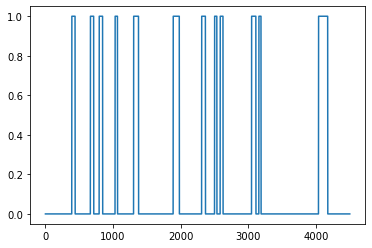

In [7]:
plt.plot(time_series[0])

In [4]:
iscfs = np.load('results/iscf_lstm_tanh-z_pca-k100.npy')

In [5]:
matchup_id = 0
iscfs = iscfs[matchup_id]

In [7]:
iscfs.shape

(8, 6, 4501, 100, 100)

In [ ]:
ispss = np.load('results/isps_lstm_tanh-z_pca-k100.npy')

In [4]:
ls figures/topdown_ts*.mp4

figures/topdown_ts_near_m0_r0.mp4       figures/topdown_ts_pc6-iscf_m0_r3.mp4
figures/topdown_ts_pc10-iscf_m0_r0.mp4  figures/topdown_ts_pc6-iscf_m0_r4.mp4
figures/topdown_ts_pc10-iscf_m0_r1.mp4  figures/topdown_ts_pc6-iscf_m0_r5.mp4
figures/topdown_ts_pc10-iscf_m0_r2.mp4  figures/topdown_ts_pc6-iscf_m0_r6.mp4
figures/topdown_ts_pc10-iscf_m0_r3.mp4  figures/topdown_ts_pc6-iscf_m0_r7.mp4
figures/topdown_ts_pc10-iscf_m0_r4.mp4  figures/topdown_ts_pc7-iscf_m0_r0.mp4
figures/topdown_ts_pc10-iscf_m0_r5.mp4  figures/topdown_ts_pc7-iscf_m0_r1.mp4
figures/topdown_ts_pc10-iscf_m0_r6.mp4  figures/topdown_ts_pc7-iscf_m0_r2.mp4
figures/topdown_ts_pc10-iscf_m0_r7.mp4  figures/topdown_ts_pc7-iscf_m0_r3.mp4
figures/topdown_ts_pc3-iscf_m0_r0.mp4   figures/topdown_ts_pc7-iscf_m0_r4.mp4
figures/topdown_ts_pc3-iscf_m0_r1.mp4   figures/topdown_ts_pc7-iscf_m0_r5.mp4
figures/topdown_ts_pc3-iscf_m0_r2.mp4   figures/topdown_ts_pc7-iscf_m0_r6.mp4
figures/topdown_ts_pc3-iscf_m0_r3.mp4   figures/topdown_ts_pc7-i

In [4]:
matchup = 0
matchup
repeat = 0
iscfs = np.load(f'results/iscf_lstm_tanh-z_pca-k100_m{matchup}_r{repeat}.npy')

In [5]:
iscfs.shape

(6, 4501, 100, 100)

In [10]:
pc = 3 - 1
coop_ids = [0, 5]
time_series = iscfs[coop_ids, :, pc, pc]

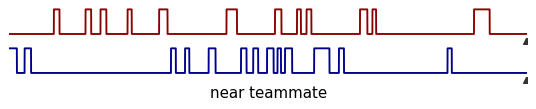

In [11]:
filename = join(base_dir, 'figures',
                f'topdown_ts_near-rad3_m{matchup_id}_r{repeat_id}.mp4')
event_video_path = time_series_top(time_series, wrap_f, map_id=0,
                                   matchup_id=0, repeat_id=0,
                                   label='near teammate',
                                   filename=filename)

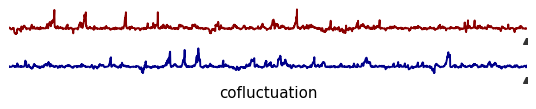

In [11]:
filename = join(base_dir, 'figures',
                f'topdown_ts_iscf_m{matchup}_r{repeat}.mp4')
event_video_path = time_series_top(time_series, wrap_f, map_id=0,
                                   matchup_id=0, repeat_id=0,
                                   label='cofluctuation',
                                   filename=filename)

Finished creating video for PC 8 repeat 0
Finished creating video for PC 8 repeat 1
Finished creating video for PC 8 repeat 2
Finished creating video for PC 8 repeat 3
Finished creating video for PC 8 repeat 4
Finished creating video for PC 8 repeat 5
Finished creating video for PC 8 repeat 6
Finished creating video for PC 8 repeat 7


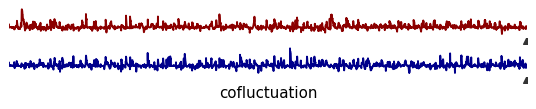

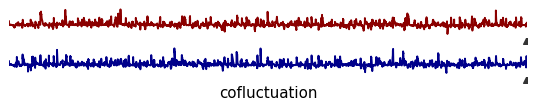

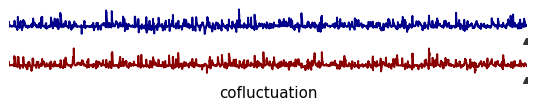

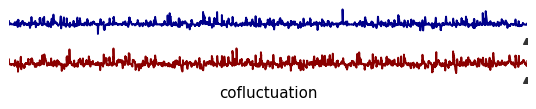

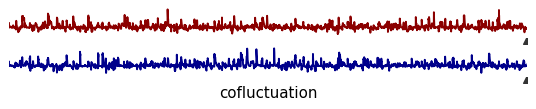

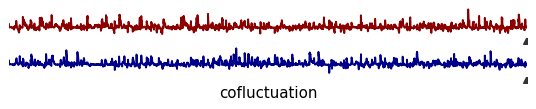

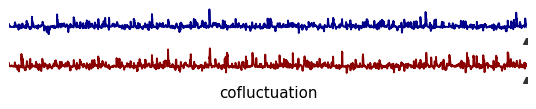

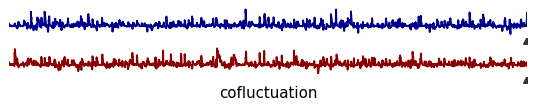

In [8]:
coop_ids = (0, 5)
#pcs = [3, 6, 10]
#pcs = [4, 7, 9]
pcs = [8]

for pc in pcs:
    pc = pc - 1
    
    for repeat_id in np.arange(8):
        time_series = iscfs[repeat_id, coop_ids, :, pc, pc]
        
        filename = join(base_dir, 'figures',
                        f'topdown_ts_pc{pc + 1}-iscf_m{matchup_id}_r{repeat_id}.mp4')
        event_video_path = time_series_top(time_series, wrap_f, map_id=0,
                                   matchup_id=matchup_id, repeat_id=repeat_id,
                                   label='cofluctuation',
                                   filename=filename)
        print(f"Finished creating video for PC{pc + 1} repeat {repeat_id}")

In [7]:
plt.close(); plt.clf()

<Figure size 432x288 with 0 Axes>

In [10]:
Video('figures/topdown_ts_pc8-iscf_m0_r1.mp4', embed=True)

In [18]:
iscfs.shape

(8, 6, 4501, 100, 100)